# Modelo Fraud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_percentage_error, mean_squared_error, r2_score
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df_fraud = pd.read_csv('data_fraud.csv')

In [3]:
df_fraud.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [3]:
X, y = df_fraud.drop('isFraud', axis=1), df_fraud['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD

def encode_data_with_svd(df_train, df_test, n_components=100, batch_size=10000):
    object_df_train = df_train.select_dtypes(include=['object'])
    object_df_test = df_test.select_dtypes(include=['object'])

    encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
    encoder.fit(object_df_train)
    
    categories = encoder.categories_
    encoded_columns = [
        f"{col}_{category}" 
        for i, col in enumerate(object_df_train.columns) 
        for category in categories[i][1:]
    ]
    
    def transform_and_svd_in_batches(df, encoder, n_components, batch_size):
        n = len(df)
        svd = TruncatedSVD(n_components=n_components)
        for i in range(0, n, batch_size):
            batch = df.iloc[i:i+batch_size]
            encoded_batch = encoder.transform(batch)
            svd.fit(encoded_batch)
            yield pd.DataFrame(svd.transform(encoded_batch), columns=[f'SVD_{i}' for i in range(n_components)])
    
    svd_train_batches = list(transform_and_svd_in_batches(object_df_train, encoder, n_components, batch_size))
    svd_test_batches = list(transform_and_svd_in_batches(object_df_test, encoder, n_components, batch_size))
    
    svd_df_train = pd.concat(svd_train_batches, axis=0).reset_index(drop=True)
    svd_df_test = pd.concat(svd_test_batches, axis=0).reset_index(drop=True)
    
    df_train_non_categorical = df_train.drop(columns=object_df_train.columns).reset_index(drop=True)
    df_test_non_categorical = df_test.drop(columns=object_df_train.columns).reset_index(drop=True)
    
    df_train_encoded = pd.concat([df_train_non_categorical, svd_df_train], axis=1)
    df_test_encoded = pd.concat([df_test_non_categorical, svd_df_test], axis=1)
    
    return df_train_encoded, df_test_encoded

df_train_encoded, df_test_encoded = encode_data_with_svd(df_train, df_test, n_components=100, batch_size=10000)


In [8]:
print(df_train_encoded.shape)
print(df_test_encoded.shape)

(472432, 503)
(118108, 503)


In [5]:
correlation = df_train_encoded.drop('isFraud', axis=1).corrwith(df_train_encoded['isFraud']).apply(abs).sort_values(ascending=False)
correlation.head()

V257    0.387404
V246    0.371294
V244    0.368243
V242    0.364785
V201    0.332932
dtype: float64

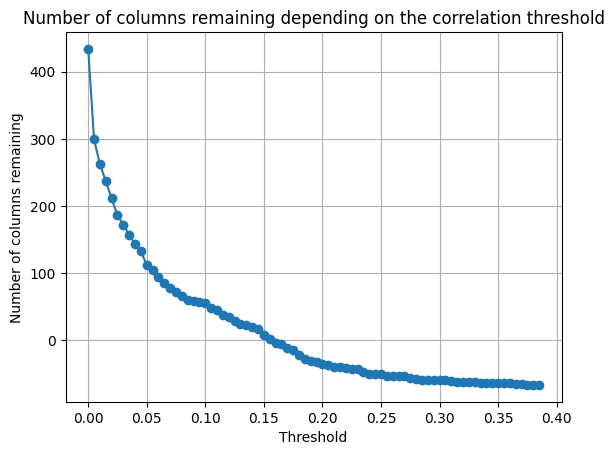

In [6]:
import numpy as np


def plot_correlation_threshold(correlation, df_train):
    thresholds = np.arange(0, correlation[0], 0.005)
    nb_col_remaining = []

    for threshold in thresholds:
        columns_to_drop = correlation[correlation < threshold].index
        nb_col_remaining.append(df_train.shape[1] - len(columns_to_drop))

    plt.plot(thresholds, nb_col_remaining, marker='o')
    plt.title('Number of columns remaining depending on the correlation threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Number of columns remaining')
    plt.grid(True)
    plt.show()

plot_correlation_threshold(correlation, df_train)


In [7]:
def filter_data_with_correlation(df_train, df_test, correlation_threshold=0.05):
    columns_to_drop = correlation[correlation < correlation_threshold].index
    columns_to_drop = [col for col in columns_to_drop if col in df_train.columns]  # Verificación de existencia de columnas
    df_train_filtered = df_train.drop(columns=columns_to_drop, errors='ignore')  # Usamos errors='ignore' para evitar errores si la columna ya ha sido eliminada
    df_test_filtered = df_test.drop(columns=columns_to_drop, errors='ignore')  # Usamos errors='ignore' para evitar errores si la columna ya ha sido eliminada
    return df_train_filtered, df_test_filtered

# Filtra los datos basados en la correlación y obtén los DataFrames filtrados
df_train_filtered, df_test_filtered = filter_data_with_correlation(df_train, df_test)

print(df_train_filtered.shape)
print(df_test_filtered.shape)

(472432, 206)
(118108, 206)


In [73]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred), 3)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

In [9]:
def perform_imputation_and_return_data(df_train_filtered, selected_vars):
    results_imputation = pd.DataFrame(columns=['features', 'max_iters', 'CPU time', "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
    nb_res = 0
    features = [5, 10, 20, 50]
    iters = [5, 10, 20, 50]

    df_train_filtered = df_train_filtered[selected_vars]
    X_train, y_train = df_train_filtered.drop('isFraud', axis=1), df_train_filtered['isFraud']
    X_train_imputation, X_test_imputation, y_train_imputation, y_test_imputation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    imputations = {}

    for max_iter in iters:
        for n_nearest_features in features:
            print(f"Training with n_nearest_features: {n_nearest_features}, max_iter: {max_iter}")
            imputer = IterativeImputer(n_nearest_features=n_nearest_features, max_iter=max_iter, random_state=42)
            pipeline = Pipeline(steps=[('i', imputer), ('m', RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42))])

            start_time = time()
            pipeline.fit(X_train_imputation, y_train_imputation)
            end_time = time()

            eval = evaluate_model(pipeline, X_test_imputation, y_test_imputation)

            results_imputation.loc[nb_res] = [n_nearest_features, max_iter, round(end_time - start_time, 1),
                                              eval['Accuracy'], eval['Precision'], eval['Recall'],
                                              eval['F1 Score'], eval['AUC ROC']]
            nb_res += 1
            print()
            

            imputations[f'n_nearest_features_{n_nearest_features}_max_iter_{max_iter}'] = imputer.transform(X_train)

    return results_imputation, imputations

selected_vars = ['D2', 'D4', 'D5', 'D8', 'D10', 'D15', 'V18', 'V30', 'V34', 'V36', 'V56', 'V62', 
                 'V74', 'V75', 'V87', 'V142', 'V145', 'V147', 'V162', 'V165', 'V169', 'V176', 'V184', 
                 'V220', 'V222', 'V232', 'V239', 'V251', 'V261', 'V281', 'V282', 'V283', 'V303', 
                 'id_01', 'id_04', 'id_07', 'isFraud']

results_imputation, imputations = perform_imputation_and_return_data(df_train_filtered, selected_vars)


Training with n_nearest_features: 5, max_iter: 5
AUC ROC: 0.8351969847529948

Training with n_nearest_features: 10, max_iter: 5
AUC ROC: 0.8373867001909804

Training with n_nearest_features: 20, max_iter: 5
AUC ROC: 0.8328243226839825

Training with n_nearest_features: 50, max_iter: 5
AUC ROC: 0.8379689988488553

Training with n_nearest_features: 5, max_iter: 10
AUC ROC: 0.8351572606593756

Training with n_nearest_features: 10, max_iter: 10
AUC ROC: 0.834837059164071

Training with n_nearest_features: 20, max_iter: 10
AUC ROC: 0.8349866893873729

Training with n_nearest_features: 50, max_iter: 10
AUC ROC: 0.8353273579470393

Training with n_nearest_features: 5, max_iter: 20
AUC ROC: 0.8411044780480899

Training with n_nearest_features: 10, max_iter: 20
AUC ROC: 0.838619339333645

Training with n_nearest_features: 20, max_iter: 20
AUC ROC: 0.8346344187264101

Training with n_nearest_features: 50, max_iter: 20
AUC ROC: 0.8358250981223614

Training with n_nearest_features: 5, max_iter: 50

In [10]:
print(results_imputation.head(16))

    features  max_iters  CPU time  Accuracy  Precision    Recall  f1-score  \
0        5.0        5.0      31.7  0.970324   0.889036  0.198350  0.324337   
1       10.0        5.0      40.1  0.970292   0.867168  0.203949  0.330231   
2       20.0        5.0      64.3  0.970366   0.886571  0.200413  0.326923   
3       50.0        5.0     120.6  0.969827   0.869210  0.188034  0.309183   
4        5.0       10.0      43.5  0.970483   0.896325  0.201297  0.328761   
5       10.0       10.0      60.0  0.970102   0.880697  0.193634  0.317468   
6       20.0       10.0     106.3  0.970123   0.876984  0.195402  0.319595   
7       50.0       10.0     215.2  0.969625   0.879536  0.178603  0.296913   
8        5.0       20.0      65.9  0.970303   0.884666  0.198939  0.324832   
9       10.0       20.0      99.3  0.970419   0.878481  0.204539  0.331819   
10      20.0       20.0     190.3  0.970070   0.881242  0.192455  0.315917   
11      50.0       20.0     404.7  0.969774   0.877637  0.183908

In [9]:
selected_vars = ['D2', 'D4', 'D5', 'D8', 'D10', 'D15', 'V18', 'V30', 'V34', 'V36', 'V56', 'V62', 
                 'V74', 'V75', 'V87', 'V142', 'V145', 'V147', 'V162', 'V165', 'V169', 'V176', 'V184', 
                 'V220', 'V222', 'V232', 'V239', 'V251', 'V261', 'V281', 'V282', 'V283', 'V303', 
                 'id_01', 'id_04', 'id_07', 'isFraud']

df_train_final = df_train_filtered[selected_vars]
df_test_final = df_test_filtered[selected_vars]

In [10]:
data_train = df_train_final.drop(df_train_final[df_train_final['isFraud'] == 0].sample(n=df_train_final[df_train_final['isFraud'] == 0].shape[0]-16421).index)
print(data_train.shape)

(32842, 37)


In [11]:
X_train, y_train = data_train.drop('isFraud', axis=1), data_train['isFraud']
X_test, y_test = df_test_final.drop('isFraud', axis=1), df_test_final['isFraud']

In [13]:
ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

print("Resampling completado con éxito.")

Resampling completado con éxito.


In [14]:
def calculate_percentage(count, total):
    return round((count / total) * 100, 1)

total_train = len(y_train)
total_train_res = len(y_train_res)
total_test = len(y_test)

print("Conjunto de entrenamiento original")
print(f"Clase 0: {y_train.tolist().count(0)} ({calculate_percentage(y_train.tolist().count(0), total_train)}%)")
print(f"Clase 1: {y_train.tolist().count(1)} ({calculate_percentage(y_train.tolist().count(1), total_train)}%)")
print()

print("Conjunto de entrenamiento resampleado")
print(f"Clase 0: {y_train_res.tolist().count(0)} ({calculate_percentage(y_train_res.tolist().count(0), total_train_res)}%)")
print(f"Clase 1: {y_train_res.tolist().count(1)} ({calculate_percentage(y_train_res.tolist().count(1), total_train_res)}%)")
print()

print("Conjunto de prueba")
print(f"Clase 0: {y_test.tolist().count(0)} ({calculate_percentage(y_test.tolist().count(0), total_test)}%)")
print(f"Clase 1: {y_test.tolist().count(1)} ({calculate_percentage(y_test.tolist().count(1), total_test)}%)")


Conjunto de entrenamiento original
Clase 0: 16421 (50.0%)
Clase 1: 16421 (50.0%)

Conjunto de entrenamiento resampleado
Clase 0: 16421 (50.0%)
Clase 1: 16421 (50.0%)

Conjunto de prueba
Clase 0: 113866 (96.4%)
Clase 1: 4242 (3.6%)


In [71]:
nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'scalers': {
            'scaler': [None],
        },
        'grid': {
            'model__max_depth': [None, 10, 20, 30, 40, 50],
            'model__n_estimators': [10, 50, 100, 200],
        },    
    },

    {
        'name_clf': 'SVC (poly)',
        'model': SVC(random_state=42, kernel='poly', probability=True),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()],
        },
        'grid': {
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        }
    },

    {
        'name_clf': 'SVC (linear)',
        'model': SVC(random_state=42, kernel='linear', probability=True),
        'scalers': {
            'scaler': [MinMaxScaler(), StandardScaler()],
        },
        'grid': {
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        }
    },

    {
        'name_clf': 'SVC (rbf)',
        'model': SVC(random_state=42, kernel='rbf'),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()],
        },
        'grid': {
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        }
    },

    {
        'name_clf': 'SVC (sigmoid)',
        'model': SVC(random_state=42, kernel='sigmoid'),
        'scalers': {
            'scaler': [None, MinMaxScaler(), StandardScaler()],
        },
        'grid': {
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        }
    },    
]


In [32]:
results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    model_path = f"../models/{model_name}.pkl"
    
    if not os.path.exists(model_path):
        print(f'Training {model_name}...')

        model = dict_clf['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_clf['scalers'],
            **dict_clf['grid']
        }

        clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')

        start_time = time()
        clf.fit(X_train_res, y_train_res)
        end_time = time()
        duration = round(end_time - start_time, 1)
        print(f"CPU Time: {duration}s")

        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        with open(model_path, 'wb') as f:
            pickle.dump(clf, f)
    else:
        with open(model_path, 'rb') as f:
            clf = pickle.load(f)

        start_time = time()
        clf.predict(X_test[:10])
        end_time = time()
        duration = round(end_time - start_time, 1)

    eval = evaluate_model(clf, X_test, y_test)
    models[model_name] = clf

    results.loc[nb_res] = [model_name, duration, eval['Accuracy'], eval['Precision'], eval['Recall'], eval['F1 Score'], eval['AUC ROC']]
    nb_res += 1

    print()

print(results)

           Model  CPU time  Accuracy  Precision  Recall  f1-score    AUC
0  Random Forest    1314.7     0.962      0.495   0.980     0.655  0.947
1      SVC (rbf)    2958.8     0.960      0.480   0.940     0.635  0.928
2     SVC (poly)   15212.0     0.961      0.490   0.939     0.645  0.927
3   SVC (linear)   23458.3     0.937      0.355   0.914     0.515  0.902
4  SVC (sigmoid)     955.1     0.830      0.130   0.650     0.220  0.720


Podemos observar en los resultados que el modelo para la clasificación de detección de fraude en tarjetas, sería Random Forest, en ambos tiempo de computo y el resultado del AUC que es la metrica que vamos a analizar para ver el rendimiento de los modelos, con un AUC de 0.947

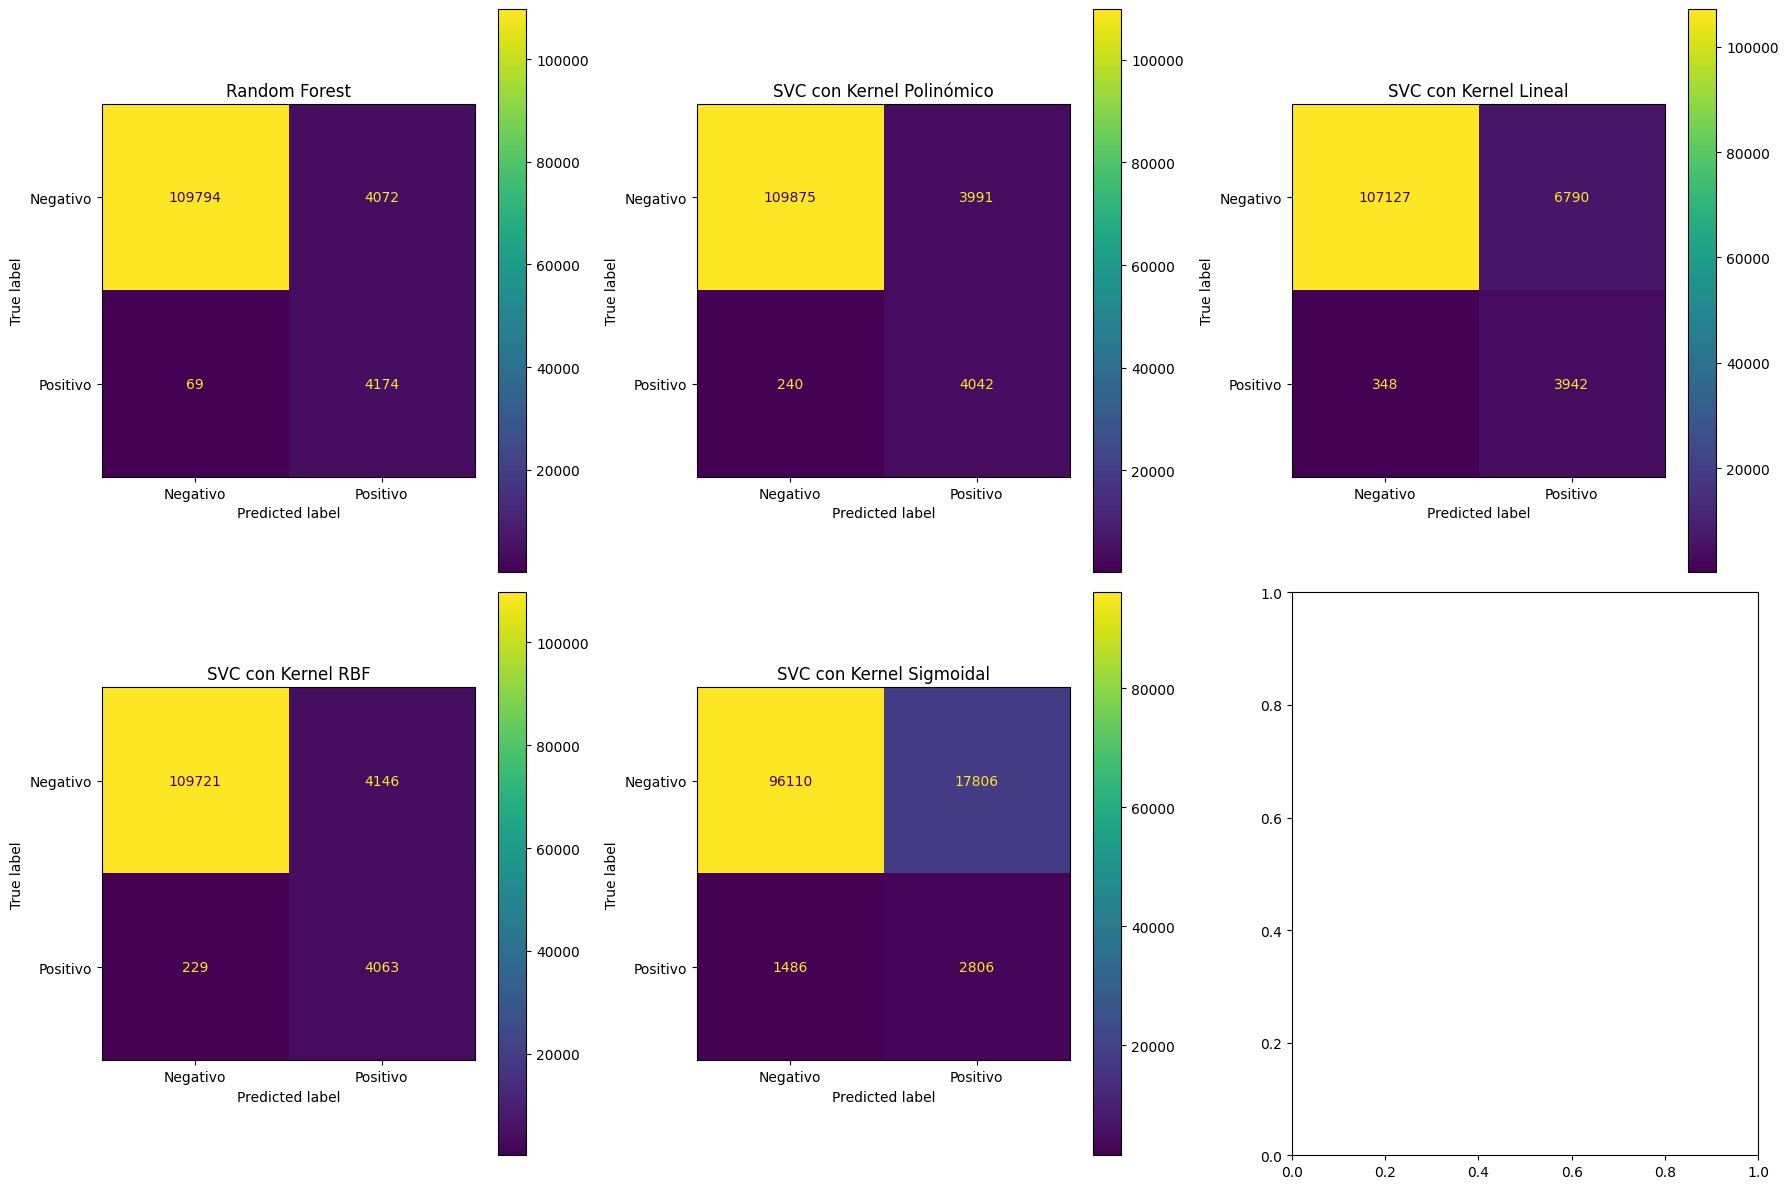

In [53]:
model_names = results["Model"]
metrics = ["CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"]
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, len(metrics) * 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(model_names, results[metric])
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.grid(axis="y")

plt.tight_layout()
plt.show()


## Con Bayes Optimization

In [79]:
import os
import pandas as pd
import pickle
from time import time
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    model_path = f"../models/{model_name}.pkl"

    if not os.path.exists(model_path):
        print(f'Training {model_name}...')

        model = dict_clf['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_clf['scalers'],
            **dict_clf['grid']
        }

        clf = BayesSearchCV(pipeline, search_spaces=param_grid, cv=5, n_iter=10, n_jobs=-1, verbose=1, scoring='roc_auc', random_state=42)

        start_time = time()
        clf.fit(X_train_res, y_train_res)
        end_time = time()
        duration = round(end_time - start_time, 1)
        print(f"CPU Time: {duration}s")

        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        with open(model_path, 'wb') as f:
            pickle.dump(clf, f)
    else:
        with open(model_path, 'rb') as f:
            clf = pickle.load(f)

        start_time = time()
        clf.predict(X_test[:10])
        end_time = time()
        duration = round(end_time - start_time, 1)

    eval = evaluate_model(clf, X_test, y_test)
    models[model_name] = clf

    results.loc[nb_res] = [model_name, duration, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

print(results)


           Model  CPU time  Accuracy  Precision  Recall  f1-score    AUC
0  Random Forest      61.5     0.963      0.490   0.991     0.656  0.974
1     SVC (poly)    7241.5     0.961      0.480   0.955     0.638  0.956
2      SVC (rbf)     492.4     0.963      0.492   0.950     0.649  0.955
3  SVC (sigmoid)     310.0     0.735      0.093   0.725     0.164  0.725


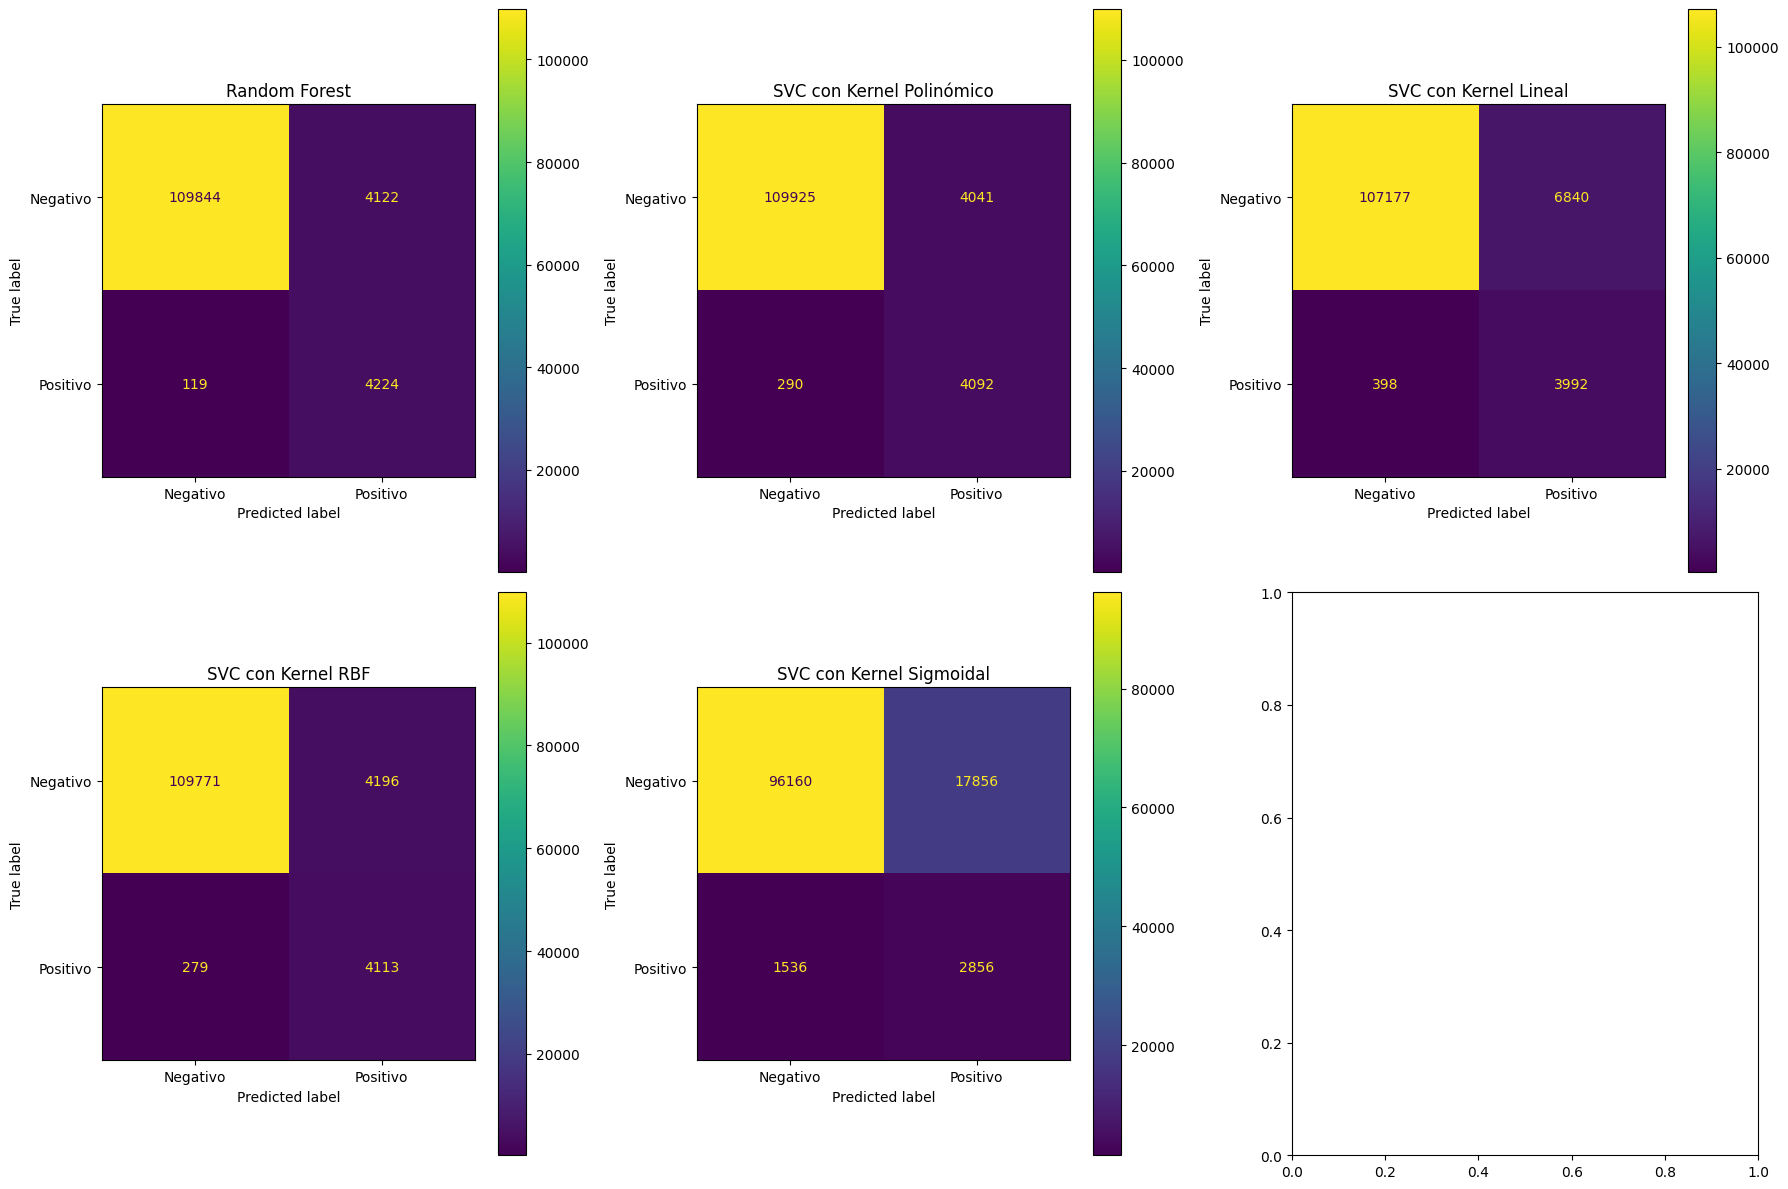

In [80]:
model_names = results["Model"]
metrics = ["CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"]
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, len(metrics) * 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(model_names, results[metric])
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.grid(axis="y")

plt.tight_layout()
plt.show()
